<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5000 non-null   int64 
 1   Age                5000 non-null   int64 
 2   Gender             5000 non-null   object
 3   SubscriptionType   5000 non-null   object
 4   MonthlyUsageHours  5000 non-null   int64 
 5   NumTransactions    5000 non-null   int64 
 6   Complaints         5000 non-null   int64 
 7   Churn              5000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 312.6+ KB


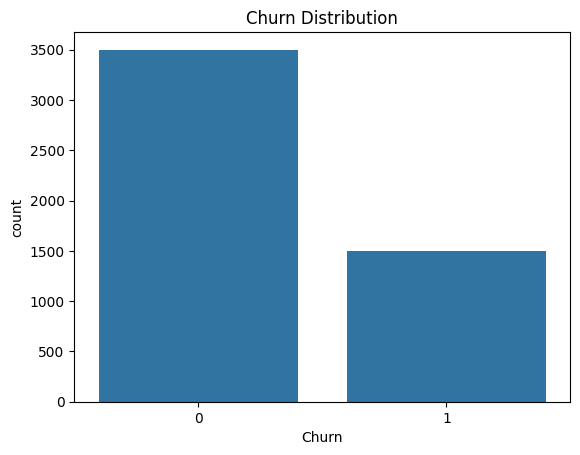

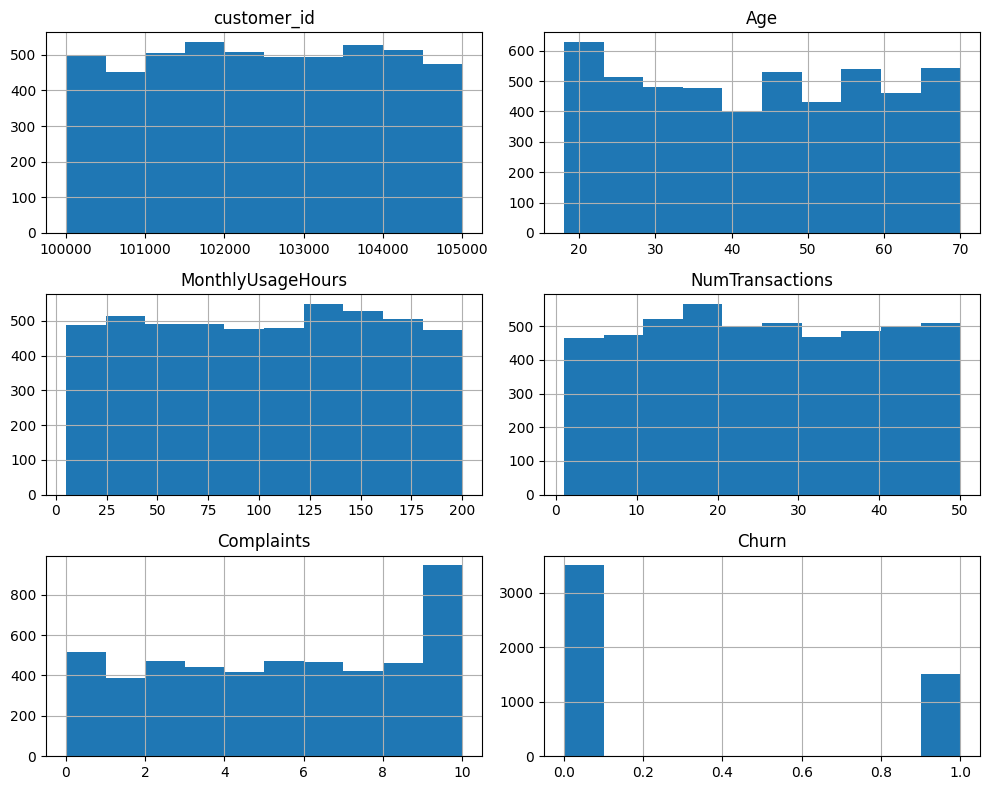

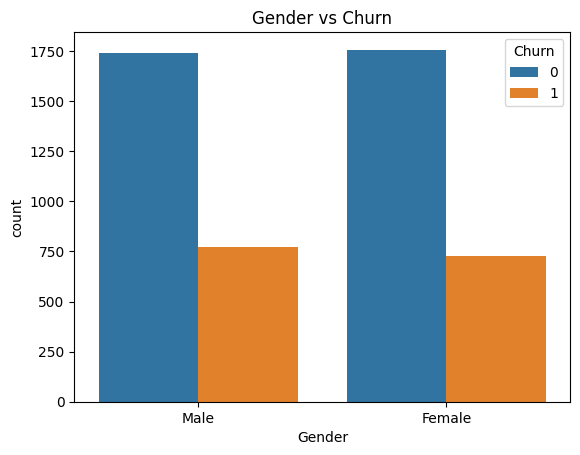

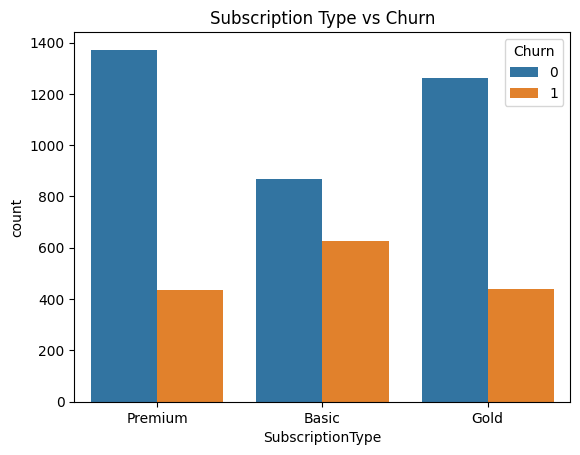

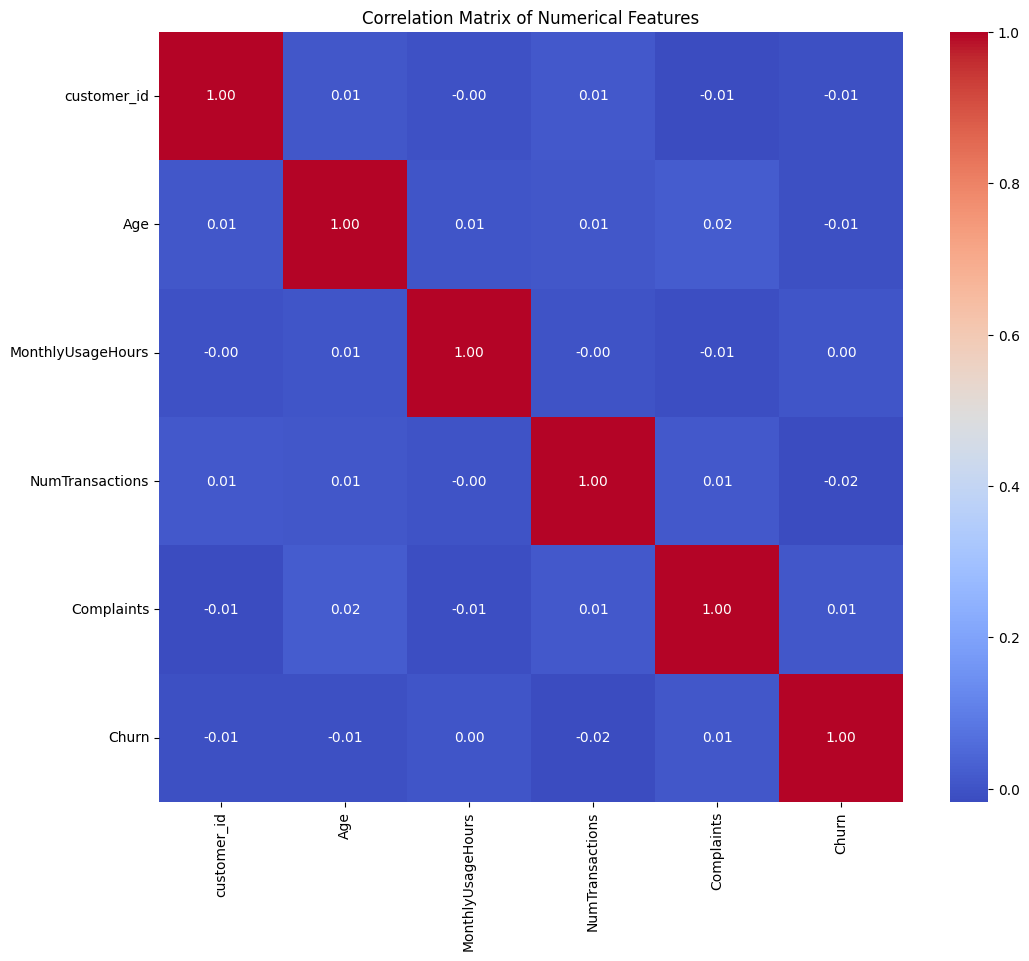

   customer_id  Age  Gender SubscriptionType  MonthlyUsageHours  \
0       100235   26    Male          Premium                120   
1       103662   34  Female            Basic                199   
2       104117   47    Male          Premium                 40   
3       100617   36    Male          Premium                 32   
4       101202   53  Female             Gold                 78   

   NumTransactions  Complaints  Churn  
0               29           9      0  
1               47           9      0  
2                6           7      0  
3               25           8      0  
4               37           3      0  

 MODEL EVALUATION
Accuracy:        0.738
Precision:       0.562
Recall:          0.577
ROC-AUC:         0.759

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81       700
           1       0.56      0.58      0.57       300

    accuracy                           0.74      1000
   

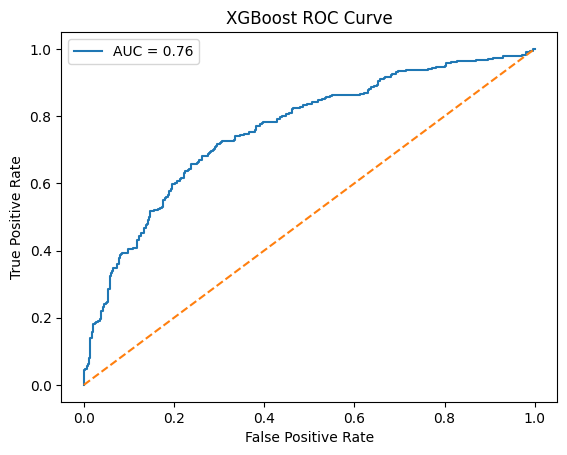

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, classification_report
)
from xgboost import XGBClassifier

df = pd.read_csv("netflix_customer_churn.csv")
df.head()

# Checking of Null Values
df.info()
df.describe(include='all')
df.isnull().sum()

# Checking for duplicate values
df.duplicated().sum()

# Churn count distribution
sns.countplot(data=df, x='Churn')
plt.title("Churn Distribution")
plt.show()

df['Churn'].value_counts(normalize=True)

# Value distribution
num_cols = df.select_dtypes(include=['int64']).columns

df[num_cols].hist(figsize=(10,8), bins=10)
plt.tight_layout()
plt.show()

sns.countplot(data=df, x="Gender", hue="Churn")
plt.title("Gender vs Churn")
plt.show()

# Compare subscription type and Churn
sns.countplot(data=df, x="SubscriptionType", hue="Churn")
plt.title("Subscription Type vs Churn")
plt.show()

# Heatmap for corrlation
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

df_path = "netflix_customer_churn.csv"
data = pd.read_csv(df_path)

print(data.head())

# Remove ID column (never predictive)
if "customer_id" in data.columns:
    data = data.drop("customer_id", axis=1)

# Create new interaction features
if {'MonthlyUsageHours', 'NumTransactions'}.issubset(data.columns):
    data['Usage_per_Transaction'] = data['MonthlyUsageHours'] / (data['NumTransactions'] + 1)

if {'Complaints', 'NumTransactions'}.issubset(data.columns):
    data['Complaints_per_Transaction'] = data['Complaints'] / (data['NumTransactions'] + 1)

# High usage flag
if 'MonthlyUsageHours' in data.columns:
    data['HighUsage'] = (data['MonthlyUsageHours'] > data['MonthlyUsageHours'].median()).astype(int)

# Tenure calculation if date columns exist
if {'JoinDate', 'EndDate'}.issubset(data.columns):
    data['JoinDate'] = pd.to_datetime(data['JoinDate'])
    data['EndDate'] = pd.to_datetime(data['EndDate'])
    data['TenureDays'] = (data['EndDate'] - data['JoinDate']).dt.days.fillna(0)

# Fill missing values for newly added features
data = data.replace([np.inf, -np.inf], 0).fillna(0)

X = data.drop("Churn", axis=1)
y = data["Churn"]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# Class imbalance ratio
pos = y_train.sum()
neg = len(y_train) - pos
scale = neg / pos  # dynamic balancing

model = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    gamma=0.3,
    min_child_weight=3,
    scale_pos_weight=scale,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\n MODEL EVALUATION")
print(f"Accuracy:        {acc:.3f}")
print(f"Precision:       {prec:.3f}")
print(f"Recall:          {rec:.3f}")
print(f"ROC-AUC:         {auc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1], '--')
plt.title("XGBoost ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
